# SageMaker Script Mode

- User can use thier own training code on SageMaker supported frameworks.
- Supported frameworks: *Scikit-learn, Spark ML, XGBoost, Tensorflow, Keras, Pytorch, MXNet, Chainer*
- Users only need to write a script without configure ML framework.
- Users cannot customize the training environment like installing additional packages.

## Example Code

The model used for this example is a basic Convolutional Neural Network (CNN).  
We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset.

#### Training is done in the following order:
1. Build development environment
2. Prepare input data
3. Modify training code to work with sagemaker
4. Test training code
5. Run training job
6. Deploy saved models

## 1. Build development environment

#### Set up the Notebook environment
Training script for demo is based on `Pytorch` framework.
- instance spec: ml.g4dn.xlarge (4vCPU + 16GB + 1GPU)
- kernel image: PyTorch 1.6 Python 3.6 GPU Optimized

## 2. Prepare input data

#### Download the CIFAR-10 dataset

I have previously downloaded the data in the `./data` directory.  
And I loaded this dataset to pytorch's `DataLoader` type.  

In [1]:
from get_cifar10 import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


#### Data preview
We can preview the sample images with data label.

[2021-06-27 13:46:16.542 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:1139 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-27 13:46:16.576 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:1139 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
     ship      deer      frog       cat


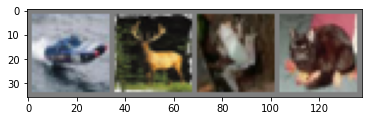

In [2]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

#### Save the dataset in S3

To transfer our dataset to training job, upload our datasets to object storage.  
We need to pass the object storage path when we start the training job.

In [3]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

train_s3_path = sagemaker_session.upload_data(path="data", 
                                       bucket=sagemaker_session.default_bucket(), 
                                       key_prefix="data/cifar10")

print(train_s3_path)

s3://sagemaker-ap-northeast-2-834160605896/data/cifar10


## 3. Modify code

#### Prepared pre-developed code
```
source
├── my_cnn.py    # CNN Model network code
└── train.py     # training and evaluation code
```

For using this code in SageMaker, I created `train_sagemaker.py` file. 

In [4]:
!diff source/train.py source/train_sagemaker.py

15a16,20
> try:
>     from sagemaker_inference import environment
> except:
>     from sagemaker_training import environment
> 
105a111,123
>     
> 
> ### Inference Code
> def model_fn(model_dir):
>     device = "cuda" if torch.cuda.is_available() else "cpu"
>     model = Model()
>     if torch.cuda.device_count() > 1:
>         logger.info("Gpu count: {}".format(torch.cuda.device_count()))
>         model = nn.DataParallel(model)
> 
>     with open(os.path.join(model_dir, "model.pth"), "rb") as f:
>         model.load_state_dict(torch.load(f))
>     return model.to(device)
117,118c135,137
<     parser.add_argument("--model-dir", type=str, default='.')
<     parser.add_argument("--data-dir", type=str, default='./data')
---
>     env = environment.Environment()
>     parser.add_argument("--model-dir", type=str, default=env.model_dir)
>     parser.add_argument("--data-dir", type=str, default=env.channel_input_dirs.get("training"))


#### What to modify

- Set <u>input data path</u> and <u>model saving path</u> to the path guided by sagemaker.
- Add model load function to deploy saved model.

## 4. Test training code

After code modification, check whether the code actually working. So, I will create a training job with 1 epoch.

#### Define training job spec

To use pytorch framework, import `PyTorch` object from sagemaker SDK.  
We can pass job spec as parameter (same as before)

In [5]:
from sagemaker.pytorch.estimator import PyTorch

# Define job spec
job_name = 'TEST-script-mode'
instance_type = 'ml.p2.xlarge'

pytorch_estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    base_job_name=job_name,
    instance_count=1,
    instance_type=instance_type,
    framework_version="1.7.1",
    py_version='py3',
    source_dir='source',
    entry_point='train_sagemaker.py',
    hyperparameters = {'epochs': 1, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (\S+)'}
    ]
)

#### Run test job

In [6]:
pytorch_estimator.fit(train_s3_path, logs=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: TEST-script-mode-2021-06-27-13-46-41-191



2021-06-27 13:46:41 Starting - Starting the training job
2021-06-27 13:46:43 Starting - Launching requested ML instances............
2021-06-27 13:47:50 Starting - Preparing the instances for training..............
2021-06-27 13:49:05 Downloading - Downloading input data..........
2021-06-27 13:50:02 Training - Downloading the training image..........................................
2021-06-27 13:53:38 Training - Training image download completed. Training in progress.........
2021-06-27 13:54:23 Uploading - Uploading generated training model.
2021-06-27 13:54:31 Completed - Training job completed


## 5. Run training job

After testing code, run actual training job with desired epochs and desired GPU instance spec.

In [8]:
from sagemaker.pytorch.estimator import PyTorch

job_name = 'DEMO-script-mode'
instance_type = 'ml.p3.2xlarge'

pytorch_estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    base_job_name=job_name,
    instance_count=1,
    instance_type=instance_type,
    framework_version="1.7.1",
    py_version='py3',
    source_dir='source',
    entry_point='train_sagemaker.py',
    hyperparameters = {'epochs': 100, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (\S+)'}
    ]
)

pytorch_estimator.fit(train_s3_path, logs=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: DEMO-script-mode-2021-06-27-13-56-01-482



2021-06-27 13:56:02 Starting - Starting the training job
2021-06-27 13:56:03 Starting - Launching requested ML instances...............
2021-06-27 13:57:25 Starting - Preparing the instances for training.................
2021-06-27 13:58:55 Downloading - Downloading input data....
2021-06-27 13:59:22 Training - Downloading the training image...............................
2021-06-27 14:02:03 Training - Training image download completed. Training in progress..............................................
2021-06-27 14:05:52 Uploading - Uploading generated training model.
2021-06-27 14:06:04 Completed - Training job completed


#### Monitor trianing

We can monitor training status, metrics in [AWS console page](
https://ap-northeast-2.console.aws.amazon.com/sagemaker/home?region=ap-northeast-2#/jobs).<br>
Or, we can also use sagemaker SDK to analysis training results.

In [9]:
sagemaker.analytics.TrainingJobAnalytics(pytorch_estimator._current_job_name, metric_names = ['accuracy']).dataframe()

,timestamp,metric_name,value
0,0.0,accuracy,16.340000
1,60.0,accuracy,32.856667
2,120.0,accuracy,44.823333
3,180.0,accuracy,49.716667


## 6. Deploy saved model

#### Deploy saved model
After training job is finished, we can deploy the model using `deploy` method of SDK.  
We can check the deployed server information in [AWS console](https://ap-northeast-2.console.aws.amazon.com/sagemaker/home?region=ap-northeast-2#/endpoints).

<U>When sagemaker deploy the model, it will use the function that we created in training code.</U>

In [10]:
cifar10_predictor = pytorch_estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: DEMO-script-mode-2021-06-27-14-07-39-970
INFO:sagemaker:Creating endpoint with name DEMO-script-mode-2021-06-27-14-07-39-970


---------------------!

#### Invoke inference API

We can invoke deployed server and check the predicted result in below.

GroundTruth:   cat ship ship plane
Predicted:   cat  car ship plane


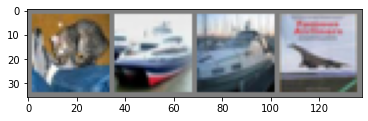

In [11]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

GroundTruth:   cat  car plane truck
Predicted:   cat  car plane truck


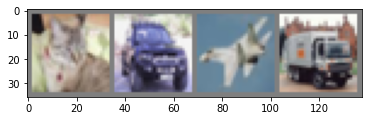

In [21]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))